In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import yaml
import numpy as np
import requests

In [44]:
# download a fresh copy of the dataset from the OSF
data_url = 'https://osf.io/f76rb//?action=download'
response = requests.get(data_url)

if response.status_code == 200:
    with open('../../data/dat.csv', 'wb') as f:
        f.write(response.content)

In [45]:
PATH_TO_DATA = '../../data/dat.csv'
PATH_TO_INDEX_INTERPRETATIONS = '../../R/value_labels.yml'

In [46]:
consultation_data = pd.read_csv(PATH_TO_DATA)

In [47]:
variable_labels = pd.read_csv('../../data/Variabelen_DJA_shortlabels.csv', encoding='ISO-8859-1')
index_interpretations = yaml.safe_load(open(PATH_TO_INDEX_INTERPRETATIONS))

In [48]:
def get_labels(data_frame, variable_labels, index_interpretations, column_name):
    column_interpretation = variable_labels.loc[variable_labels['short']==column_name]['Label'].values[0]
    relevant_column_counts = data_frame[column_name].value_counts()
    relevant_column_counts_sorted = relevant_column_counts.sort_index(ascending=True)
    
    label_indices = relevant_column_counts_sorted.index.values
    
    labels = []
    
    for index in label_indices:
        try:
            current_label_interpretation = index_interpretations[column_name][str(int(index))]
        except:
            current_label_interpretation = 'unknown'
        
        labels.append(current_label_interpretation)
    
    return labels, column_interpretation, relevant_column_counts_sorted

In [49]:
def get_plotting_data(data_frame, variable_labels, index_interpretations, column_name):
    
    (labels, column_interpretation, relevant_column_counts_sorted) = get_labels(data_frame, variable_labels, index_interpretations, column_name)
    
    values = relevant_column_counts_sorted.values
    
    return labels, values, column_interpretation

In [50]:
def finalize_figure(column_interpretation, save_folder, prefix, column_name):
    if len(prefix) > 0:
        title = '%s\n%s' % (prefix, column_interpretation)
    else:
        title = column_interpretation
        
    plt.title(title)
    
    if len(save_folder) > 0:
        plt.savefig('%s/%s.png' % (save_folder, column_name), bbox_inches='tight')

In [51]:
def format_autopct(values):
    def autopct_formatted(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return autopct_formatted

In [52]:
def create_bar_chart(data_frame, variable_labels, index_interpretations, column_name, save_folder = '', prefix = ''):
    (labels, values, column_interpretation) = \
      get_plotting_data(data_frame, variable_labels, index_interpretations, column_name)
    
    plt.figure(figsize=(6,6))
    plt.bar(x = labels, height = values)
    plt.ylabel('')
    plt.xticks(rotation = 90)
    
    finalize_figure(column_interpretation, save_folder, prefix, column_name)

In [53]:
def create_stacked_bar_chart(data_frame, variable_labels, index_interpretations, column_name_x, column_name_to_stack, save_folder = '', prefix = ''):
    (labels, column_interpretation, relevant_column_counts_sorted) = get_labels(data_frame, variable_labels, index_interpretations, column_name_x)
    
    regrouped_data = data_frame.groupby([column_name_x, column_name_to_stack])[column_name_x].count().unstack(column_name_to_stack)
    
    plt.figure()
    regrouped_data.plot(kind='bar', stacked=True)
    
    plt.xlabel('')
    plt.xticks(np.arange(0, len(labels)), labels=labels, rotation = 90)
    plt.legend(bbox_to_anchor=(1, 0.5) , loc='center left')
    
    finalize_figure(column_interpretation, save_folder, prefix, column_name_x)
    
    return labels

In [54]:
single_column_answers = ['quit', 'major_changes', 'carreer_success',\
                         'award_fair', 'award_lottery', 'award_time',\
                         'award_bandwagon', 'co_private', 'co_connections',\
                         'co_irrelevant', 'review_info',\
                         'review_confidence', 'review_informative',\
                         'review_more', 'review_government']

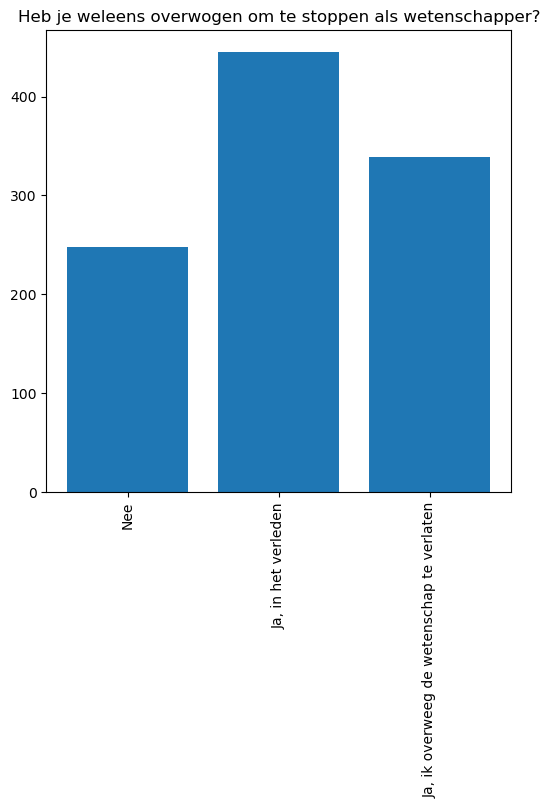

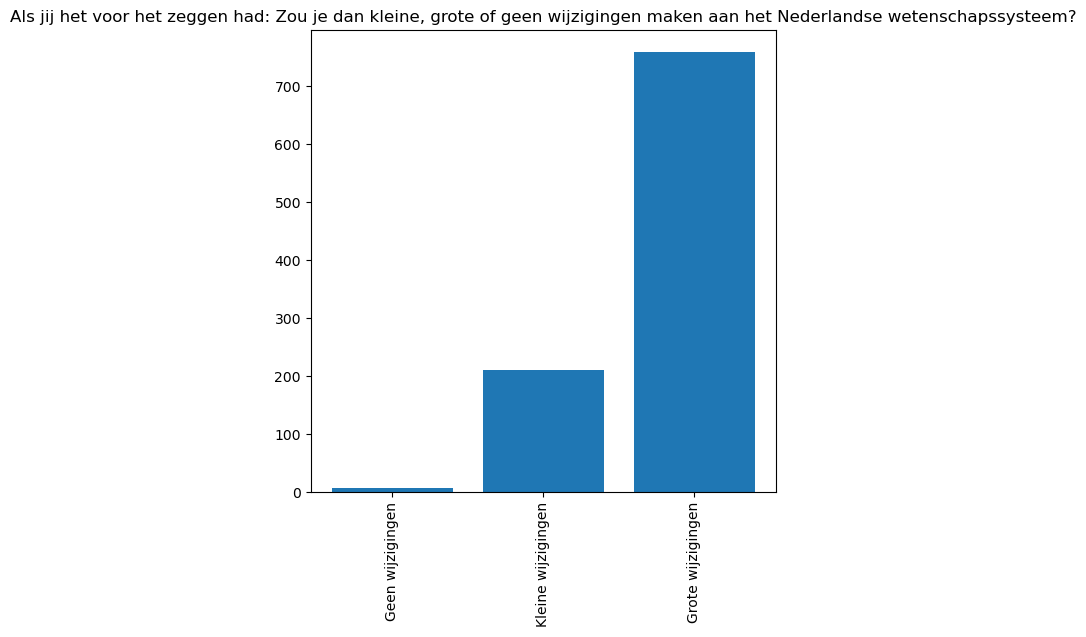

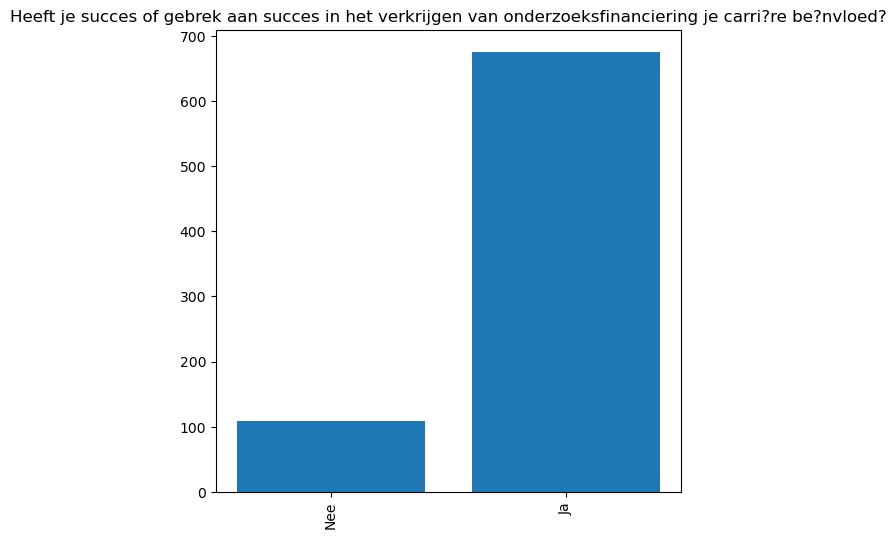

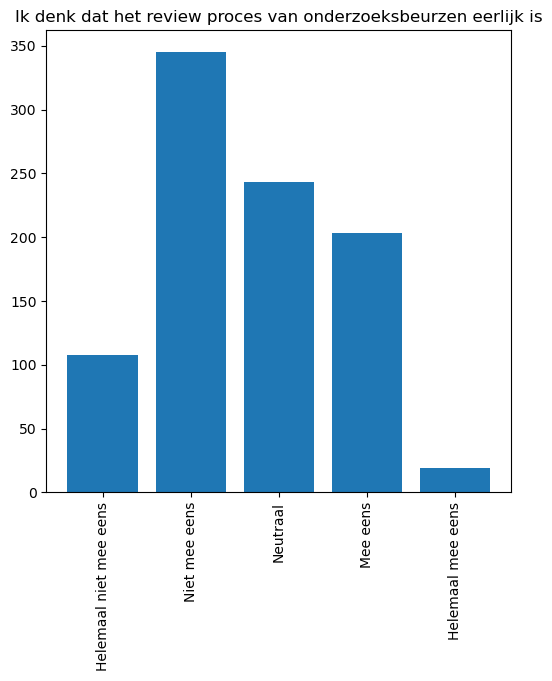

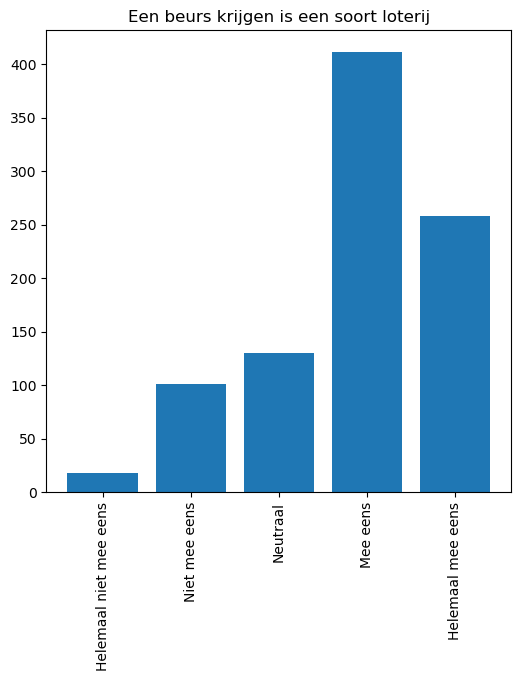

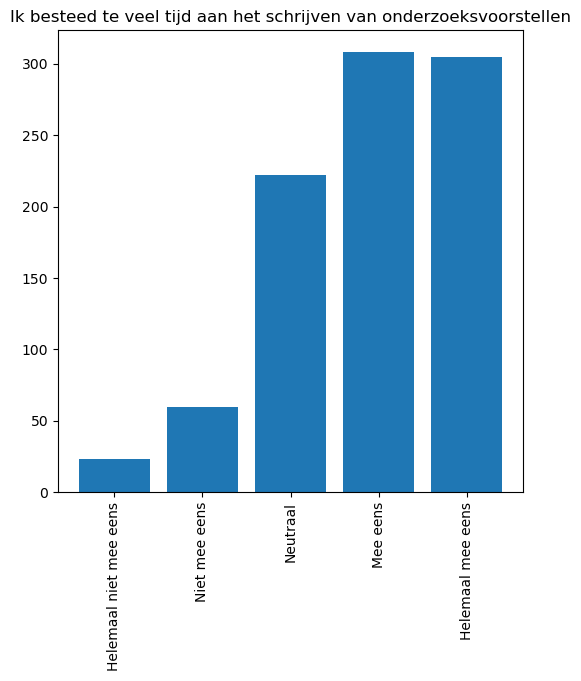

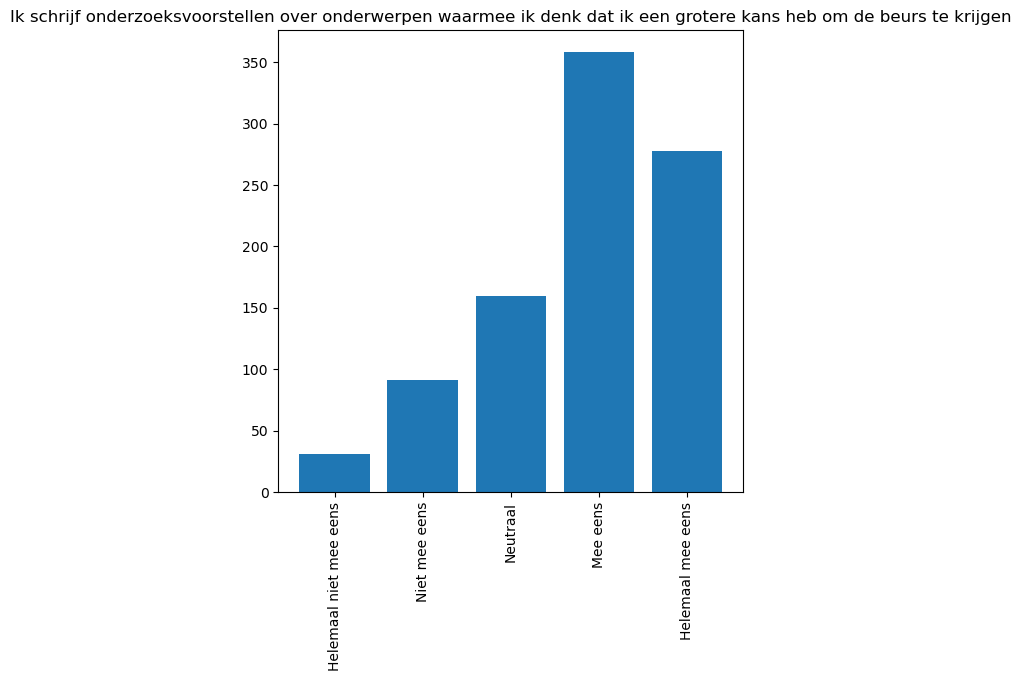

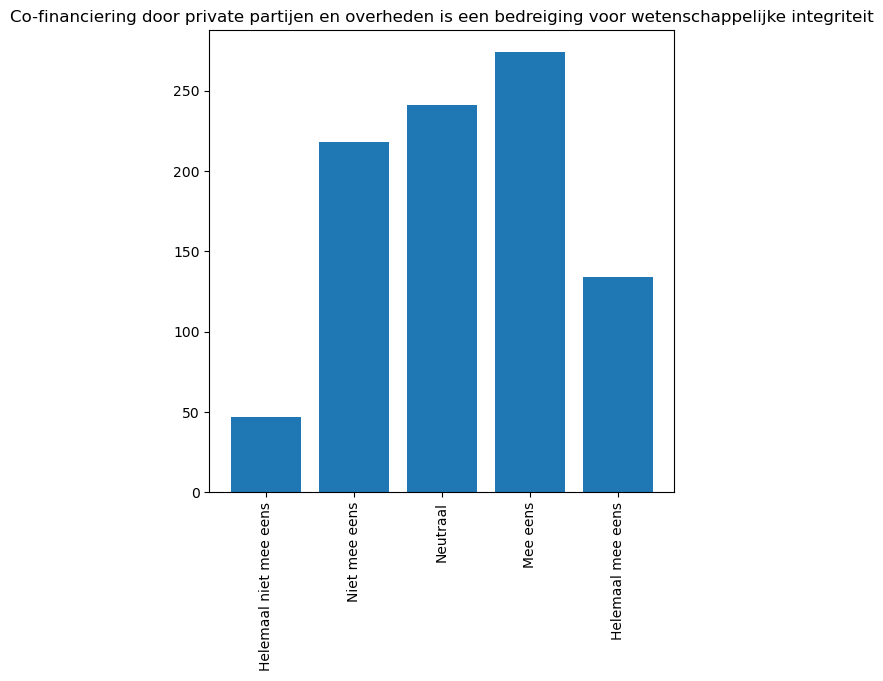

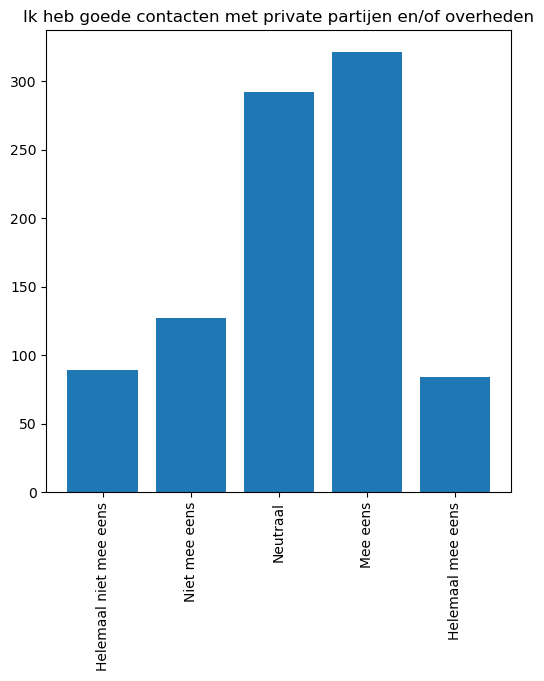

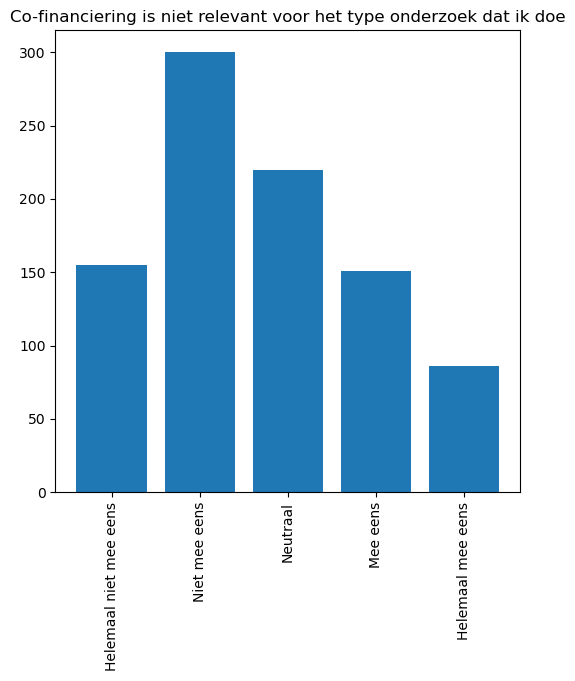

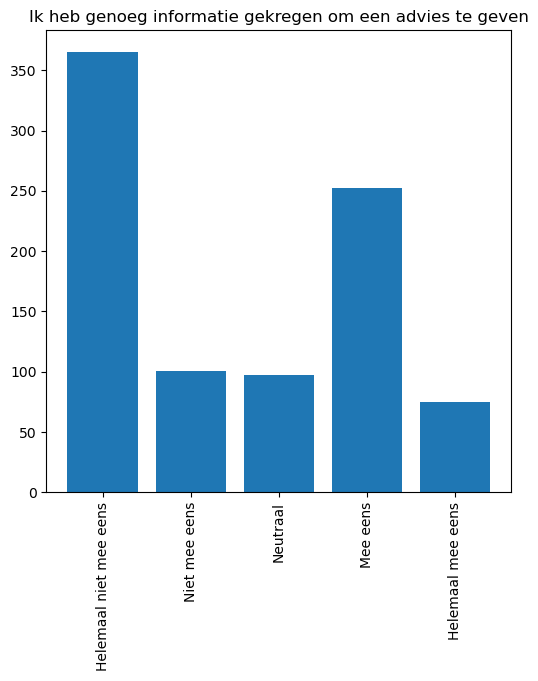

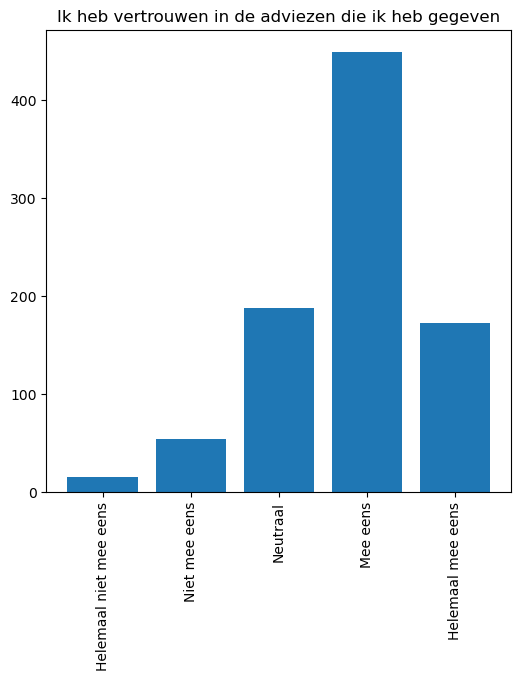

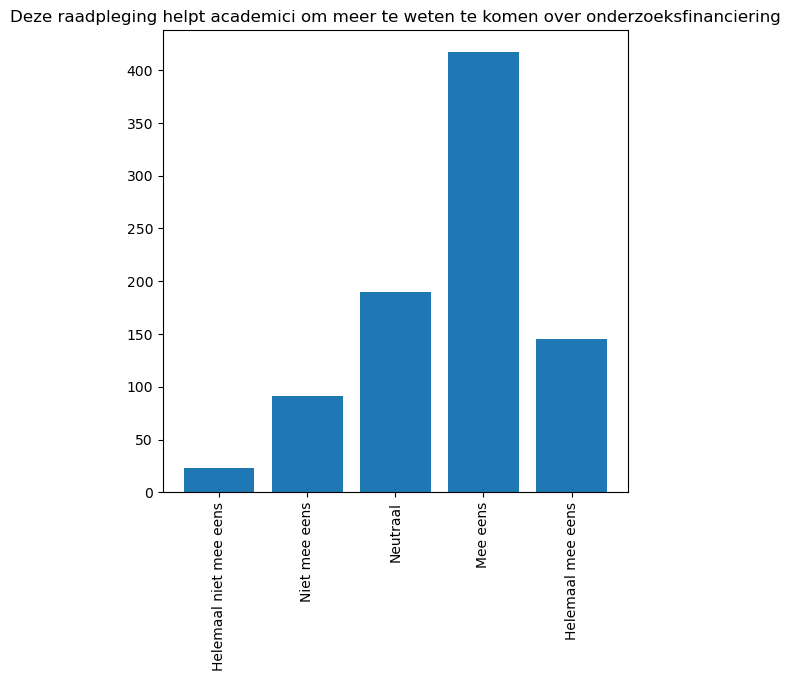

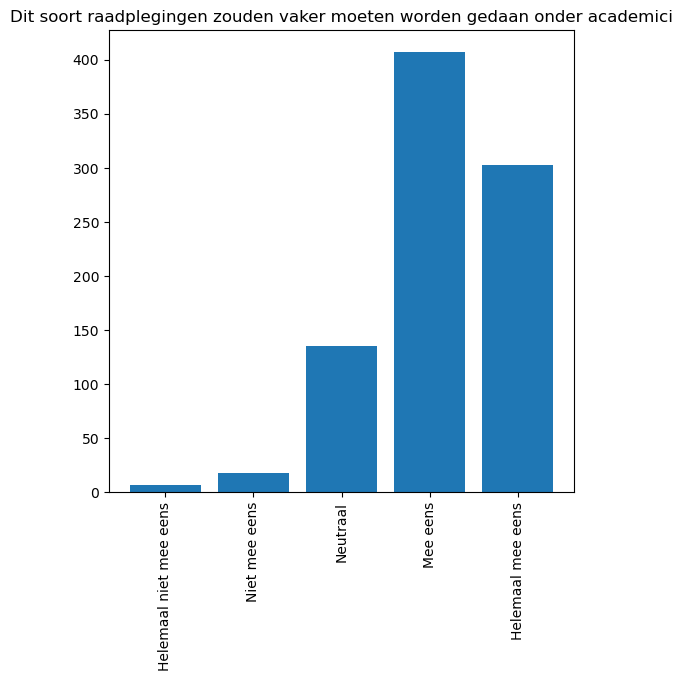

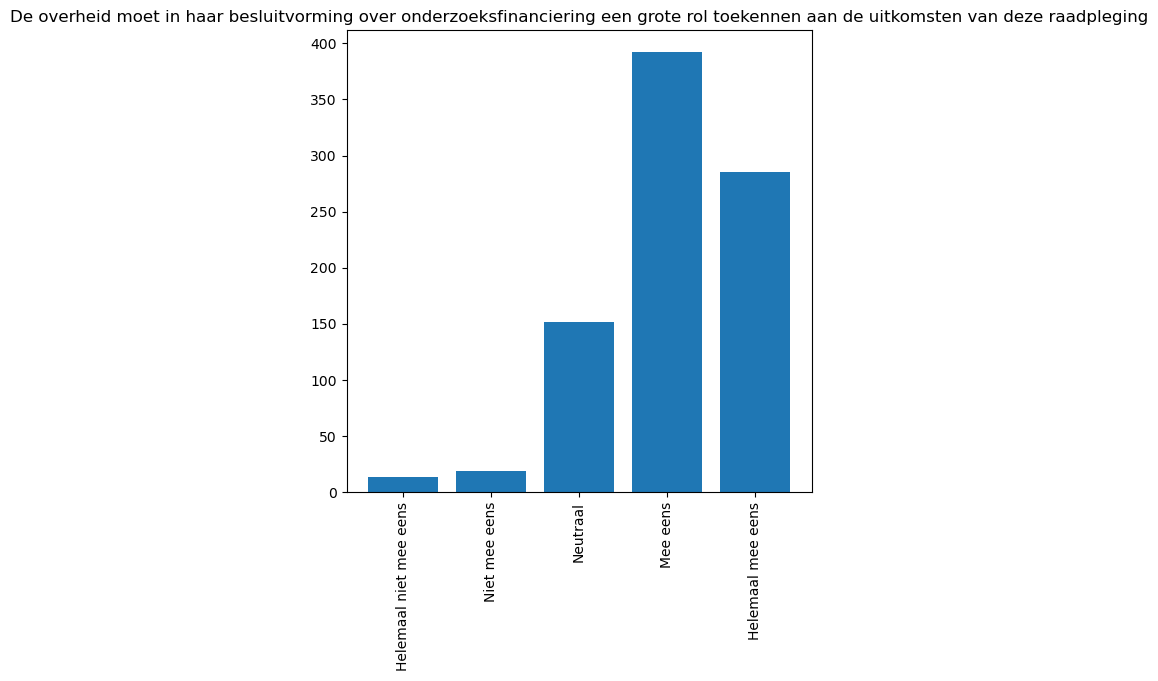

In [55]:
PLOTTING_FOLDER = 'plots_bar'
if not os.path.exists(PLOTTING_FOLDER):
    os.mkdir(PLOTTING_FOLDER)

for category in single_column_answers:
    create_bar_chart(consultation_data, variable_labels, index_interpretations, category)

/var/folders/qj/5mq62lfj5zngm8hgp_wdrph80000gn/T/ipykernel_85645/1854894288.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 640x480 with 0 Axes>

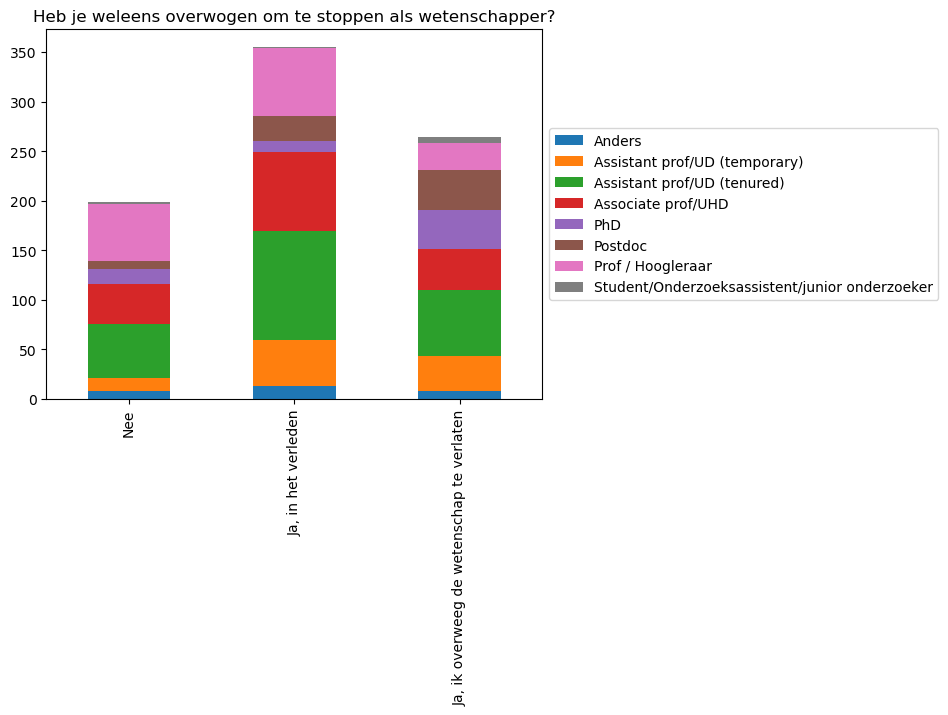

<Figure size 640x480 with 0 Axes>

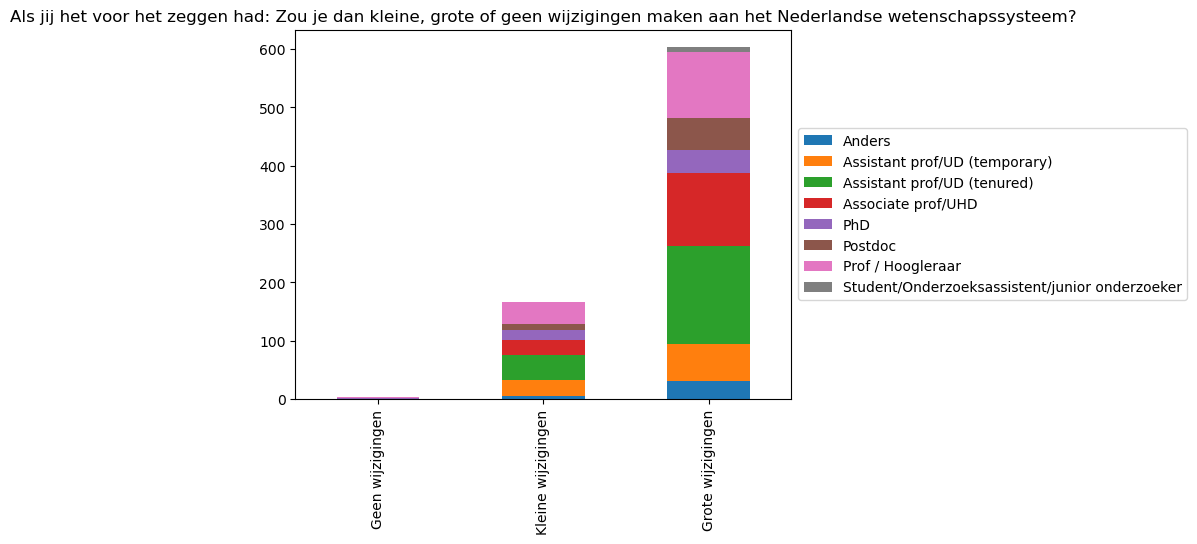

<Figure size 640x480 with 0 Axes>

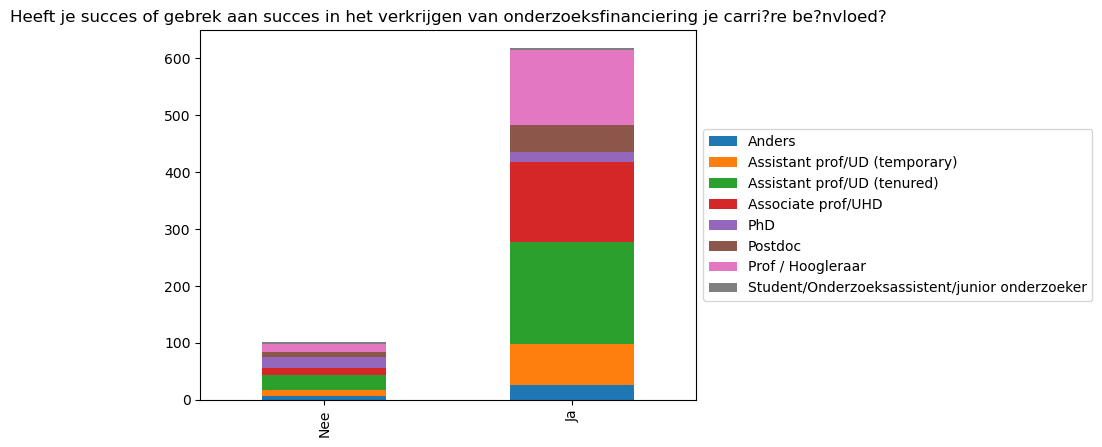

<Figure size 640x480 with 0 Axes>

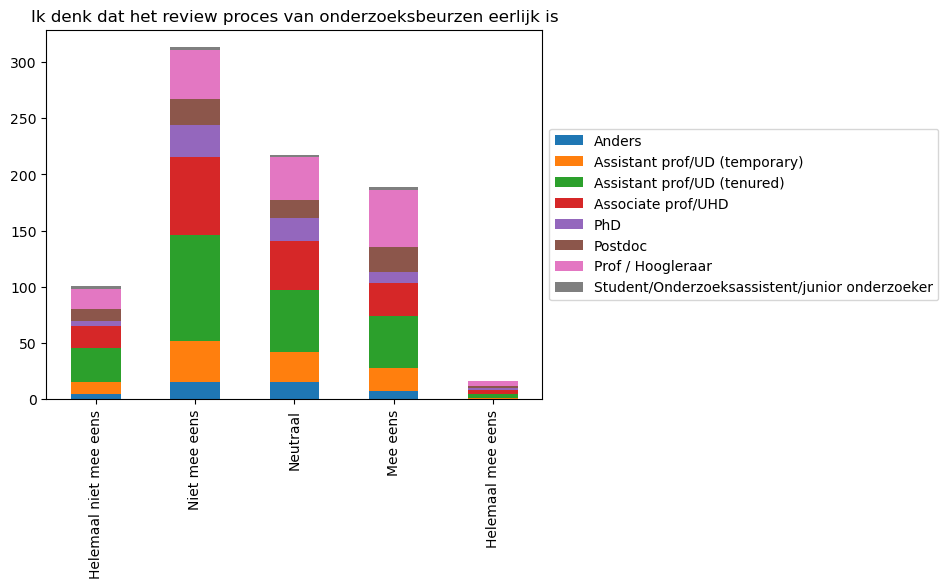

<Figure size 640x480 with 0 Axes>

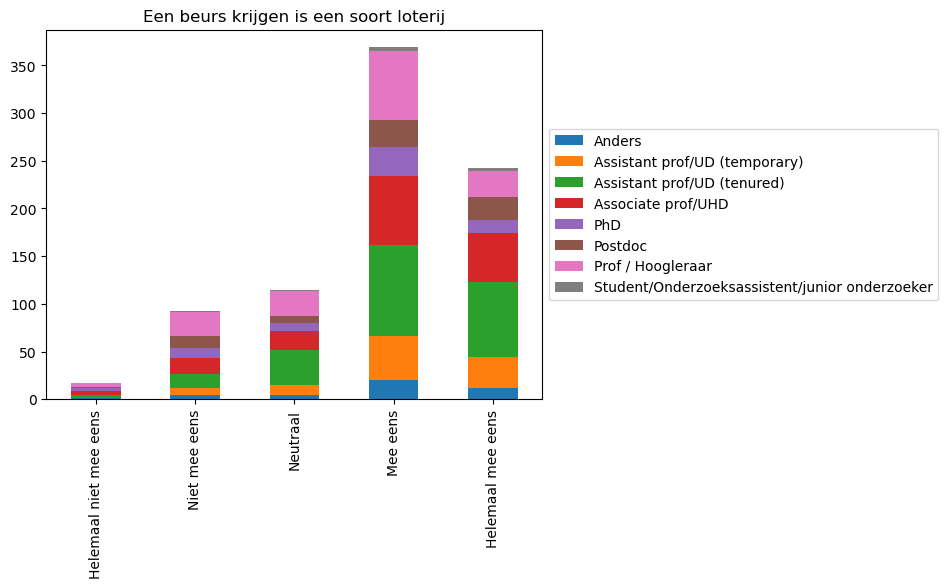

<Figure size 640x480 with 0 Axes>

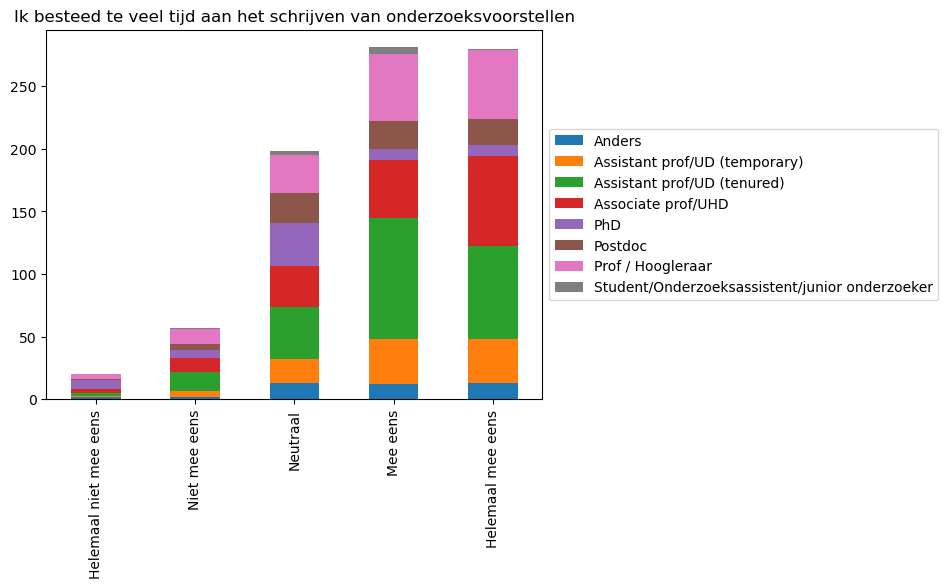

<Figure size 640x480 with 0 Axes>

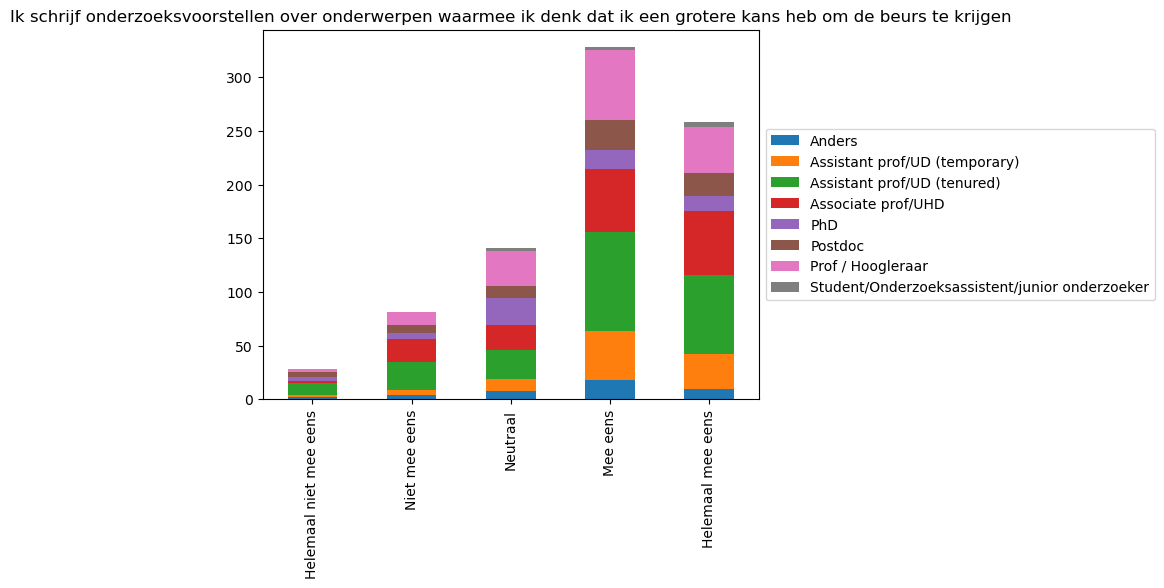

<Figure size 640x480 with 0 Axes>

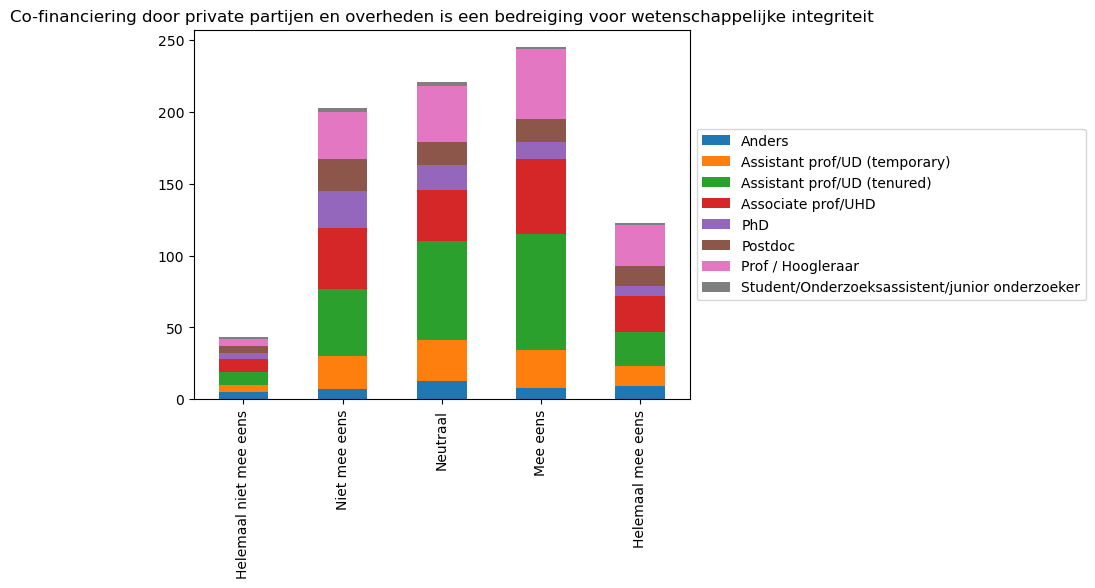

<Figure size 640x480 with 0 Axes>

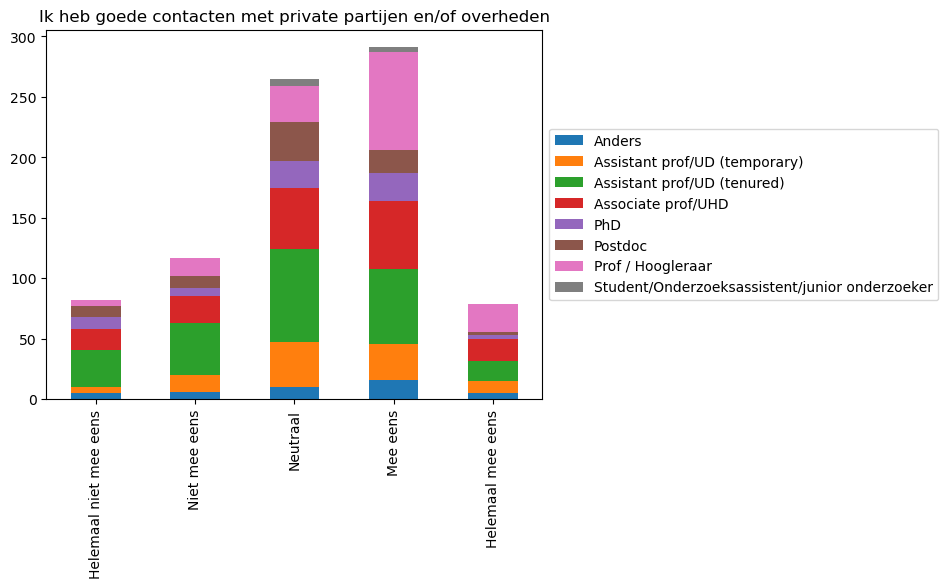

<Figure size 640x480 with 0 Axes>

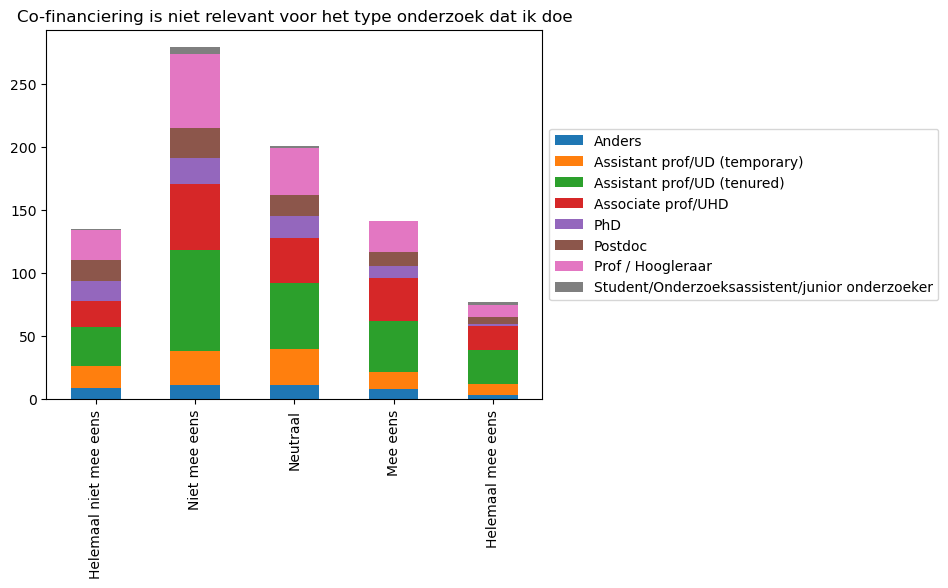

<Figure size 640x480 with 0 Axes>

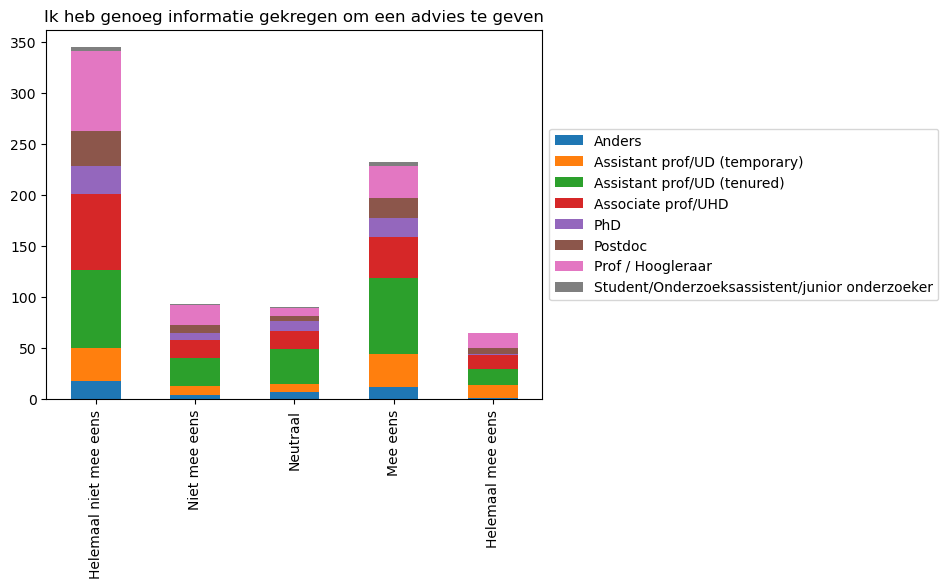

<Figure size 640x480 with 0 Axes>

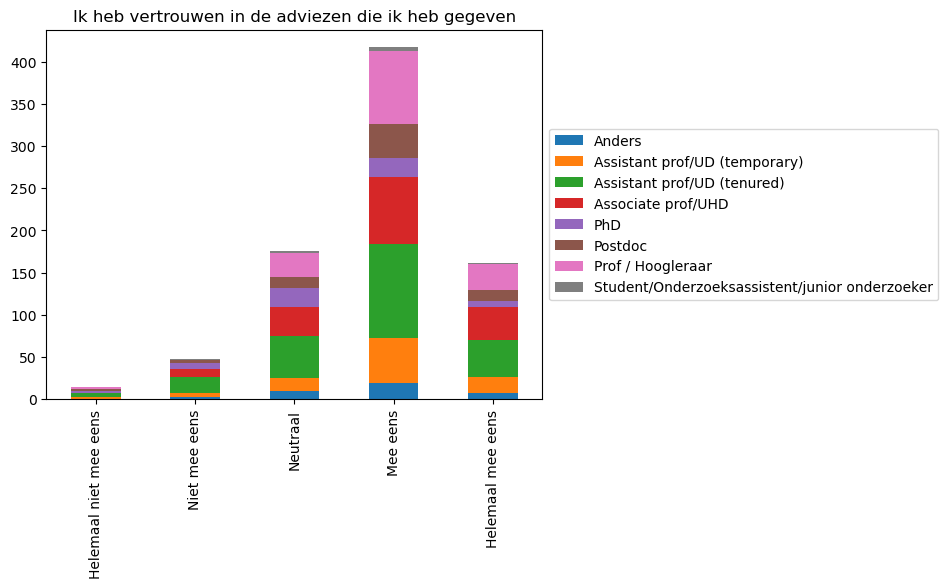

<Figure size 640x480 with 0 Axes>

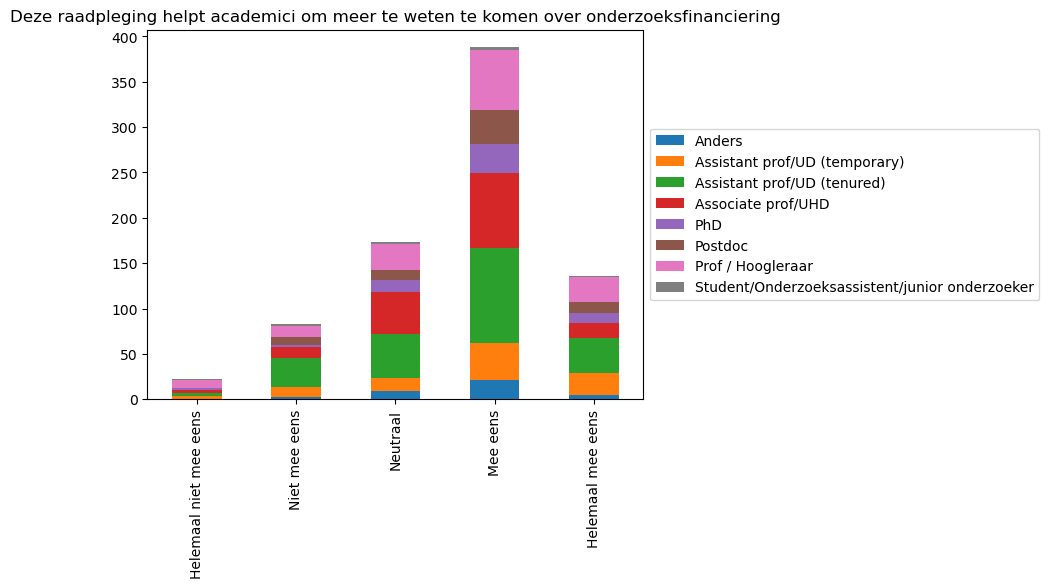

<Figure size 640x480 with 0 Axes>

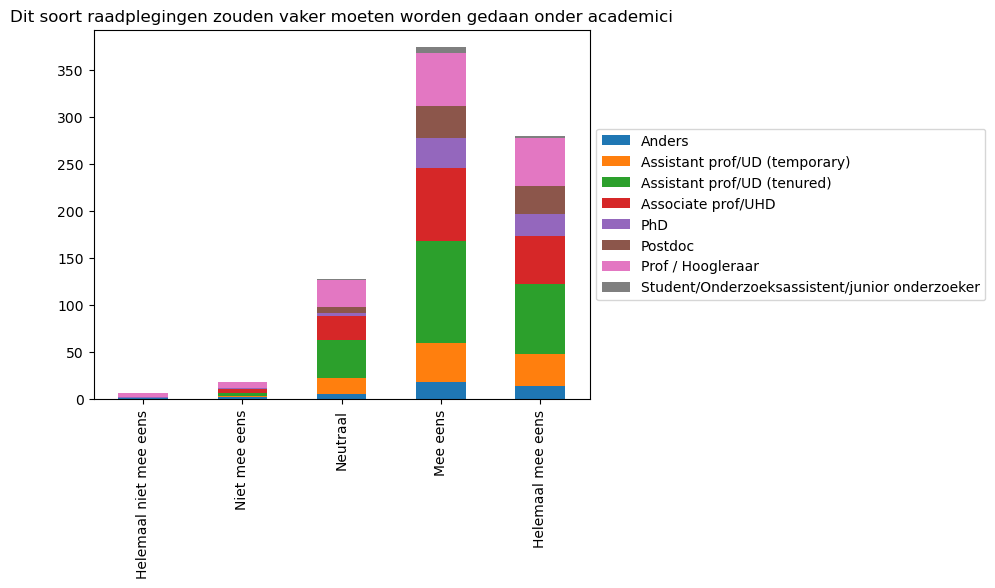

<Figure size 640x480 with 0 Axes>

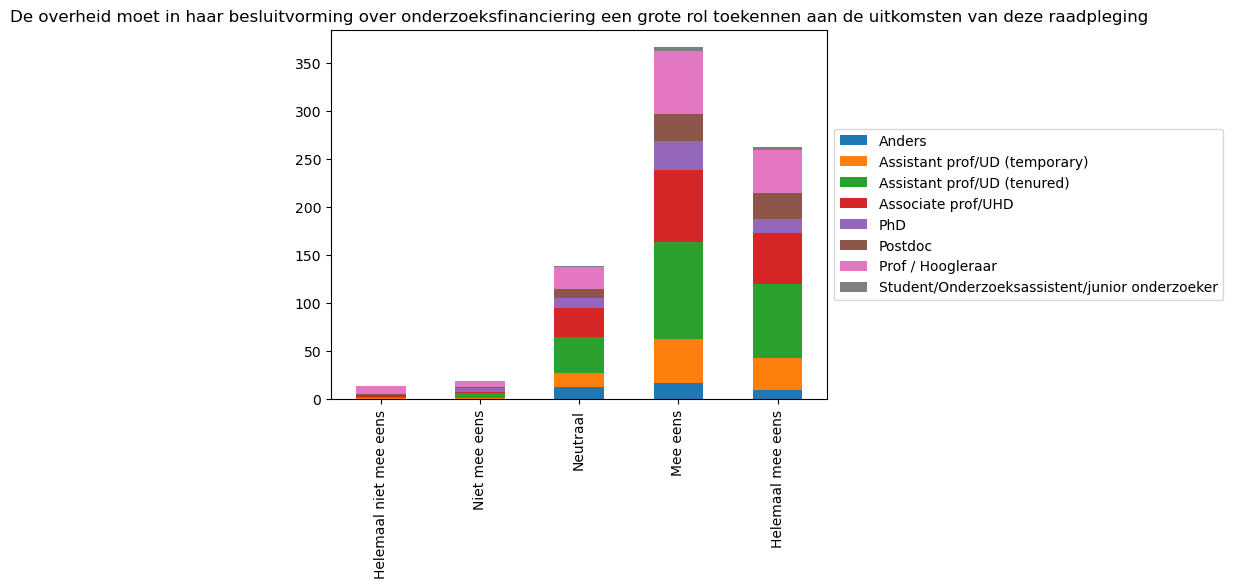

In [56]:
PLOTTING_FOLDER = 'plots_bar_stacked'
if not os.path.exists(PLOTTING_FOLDER):
    os.mkdir(PLOTTING_FOLDER)

for category in single_column_answers:
    create_stacked_bar_chart(consultation_data, variable_labels, index_interpretations, category, 'pos9', PLOTTING_FOLDER)

In [57]:
nested_questions = {'In hoeverre speelt onderstaande partij een rol bij het realiseren van je wetenschappelijke potentie?' :\
                    ['rol_supervisor', 'rol_head', 'rol_dean', 'rol_colleagues', 'rol_nwo', 'rol_ocw', 'rol_mentor'],\
                    'Wie zou het voor het zeggen moeten hebben mbt welk onderzoek gefinancierd wordt?' : \
                    ['who_researcher', 'who_manager', 'who_university', 'who_committee', 'who_government', 'who_society'],\
                    'Hoeveel tijd besteed je aan onderstaande activiteit?' :\
                    ['time_research', 'time_education', 'time_phds', 'time_management_low', 'time_management_hi',\
                     'time_service', 'time_admin', 'time_involvement', 'time_patients']
                   }

In [ ]:
PLOTTING_FOLDER = 'plots_bar_stacked'
if not os.path.exists(PLOTTING_FOLDER):
    os.mkdir(PLOTTING_FOLDER)

for question_category in nested_questions:
    for category in nested_questions[question_category]:
        create_stacked_bar_chart(consultation_data, variable_labels, index_interpretations,\
                                 category, 'pos9', PLOTTING_FOLDER, question_category)

/var/folders/qj/5mq62lfj5zngm8hgp_wdrph80000gn/T/ipykernel_85645/1854894288.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


In [ ]:
plt.close("all")